# Movie Recommender Using TF-IDF

1. Vector Similarity
2. TF-IDF

In [1]:
# Standard imports
import numpy as np
from pprint import pprint
import pandas as pd


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split

# Built-in library
import itertools
import re
import json
from typing import Union, Optional, Any
import warnings

# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure warnings and pther settings
warnings.filterwarnings("ignore")
sns.set()


def load_data(*, filename: str) -> pd.DataFrame:
    """This is used to load the data.

    Params;
        filename (str): The filepath.

    Returns:
        df (pd.DataFrame): The loaded dataframe.
    """
    df = pd.read_csv(filename)
    print(f"Shape of df: {df.shape}\n")
    return df

<br>
<hr>

## Euclidean Distance [Wikipedia]([Wikipedia](https://en.wikipedia.org/wiki/Euclidean_distance))

The `Euclidean distance` between two points in Euclidean space is the length of a line segment between the two points. It can be calculated from the Cartesian coordinates of the points using the Pythagorean theorem, therefore occasionally being called the Pythagorean distance.

* The larger the distance, the more `dissimilar` the points/words are.

$$
|| x - y ||_2 = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2 + ... + (x_d - x_d)^2 }
$$

## Cosine Similarity [Wikipedia](https://en.wikipedia.org/wiki/Cosine_similarity)

`Cosine similarity` is a measure of similarity between two sequences of numbers. For defining it, the sequences are viewed as vectors in an inner product space, and the ***cosine similarity is defined as the cosine of the angle between them***, that is, the dot product of the vectors divided by the product of their lengths. 

$$
x^T*y = ||x||_2 * ||y||_2 * cos\theta
$$

$$
cos\theta = \frac{A.B}{||A|| ||B||} = \frac{\sum_{i=1}^n{A_iB_i}}{\sqrt{\sum_{i=1}^n{A_i^2}}\sqrt{\sum_{i=1}^n{B_i^2}}}
$$

It follows that the cosine similarity does not depend on the magnitudes of the vectors, but only on their angle. The cosine similarity always belongs to the interval 
[-1,1]. i.e `-1` is the minimum value while `1` is the maximum value.

For example, two proportional vectors have a cosine similarity of 1, two orthogonal vectors have a similarity of 0, and two opposite vectors have a similarity of -1. The cosine similarity is particularly used in positive space, where the outcome is neatly bounded in [0,1]

<br>

## Cosine Distance

$$
\mathbf{Cosine Distance}  = 1 - \mathbf{Cosine Similarity}
$$

* The minimum cosine distance is `0` while the maximum distance is `2`


### Note:

* The `Cosine distance` is not a proper distance metric because it does not have the triangle inequality property.
* It's better to use `Cosine distance` instead od `Euclidean distance`.

<br>


## TF-IDF (Term Frequency Inverse Document Frequency)
The term `Term Frequency Inverse Document Frequency` refers to a numerical statistic that indicates how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. 

The `tf-idf ` value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to account for the fact that some words appear more frequently in general.



## Exercise

* Build a movie recommender system that recommends the top 5 most similar movies based on a queried movie.
* Hint:
  * Calculate the tfidf value of the queried movie
  * Compute the similarity between the queried movie and all other movies in the DB.
  * Sort by the similarity.
  * Select the top 5 mos similar movie.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


movies_db = load_data(filename="../../data/tmdb_5000_movies.csv")
movies_db.head(1)

Shape of df: (4803, 20)



,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""name"": ""alien planet""}, {""id"": 10987, ""name"": ""cgi""}, {""id"": 11399, ""name"": ""marine""}, {""id"": 13065, ""name"": ""soldier""}, {""id"": 14643, ""name"": ""battle""}, {""id"": 14720, ""name"": ""love affair""}, {""id"": 165...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [4]:
def extract_values(input_: str) -> str:
    """This returns the extracted values as a string from a list of dict.

    Params:
        input_ (str): A string containing a list of key-value pairs.

    Returns:
        result (str): A string containing the extracted values.
    """
    input_ = json.loads(input_)
    extracted_values = []
    for row in input_:
        val = row.get("name")
        if len(val.split()) == 1:
            extracted_values.append(val)
            # if the val is a 2-word genre i.e "Science Fiction"
        elif len(val.split()) > 1:
            extracted_values.append("".join(val.split()))
    result = " ".join(extracted_values)
    return result


def concat_columns(col_a: str, col_b: str) -> str:
    """This returns a concatenated string.

    Params:
        col_a (str): The 1st column.
        col_b (str): The 2nd column.

    Returns:
        result (str): The concatenated string.
    """
    result = f"{col_a} {col_b}"
    return result

In [5]:
genre = movies_db["genres"].iat[0]
genre

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [6]:
"".join("Science Fiction")

'Science Fiction'

In [7]:
extract_values(input_=genre)

'Action Adventure Fantasy ScienceFiction'

In [8]:
keywords = movies_db["keywords"].iat[0]
keywords

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [9]:
extract_values(input_=keywords)

'cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d'

In [10]:
movies = movies_db[["id", "genres", "keywords", "title"]]
movies = movies.assign(
    genres=lambda x: x["genres"].apply(extract_values),
    keywords=lambda x: x["keywords"].apply(extract_values),
)
# Concat the columns
movies["feature"] = movies.apply(
    lambda x: concat_columns(x["genres"], x["keywords"]), axis="columns"
)

movies.head(1)

,id,genres,keywords,title,feature
0,19995,Action Adventure Fantasy ScienceFiction,cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d,Avatar,Action Adventure Fantasy ScienceFiction cultureclash future spacewar spacecolony society spacetravel futuristic romance space alien tribe alienplanet cgi marine soldier battle loveaffair antiwar powerrelations mindandsoul 3d


In [11]:
X = movies["feature"]
tfidf = TfidfVectorizer(max_features=5_000)
X_tr = tfidf.fit_transform(X)
X_tr.shape

(4803, 5000)

In [12]:
# Swap the indices with the titles.
# i.e use the titles as indices.
movie_2_idx = pd.Series(data=movies.index, index=movies["title"])

movie_2_idx.sample(n=10)

title
Edmond                      3109
Mulan                        352
Beyond the Black Rainbow    4325
Think Like a Man            2813
Treading Water              3691
Hoodwinked!                 2396
The Horse Boy               4706
Bad Grandpa                 2528
Give Me Shelter             4660
Predators                   1201
dtype: int64

In [13]:
# movie title
m_title = "X-Men: Apocalypse"
# Get the index
idx = movie_2_idx.loc[m_title]
idx

64

In [14]:
query = X_tr[idx]
query

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [15]:
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [16]:
# Compute Cosine similarity
sim = cosine_similarity(query, X_tr)
sim

array([[0.01561882, 0.03213939, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
# Flatten to array to a 1-D array
sim = sim.flatten()
sim

array([0.01561882, 0.03213939, 0.        , ..., 0.        , 0.        ,
       0.        ])

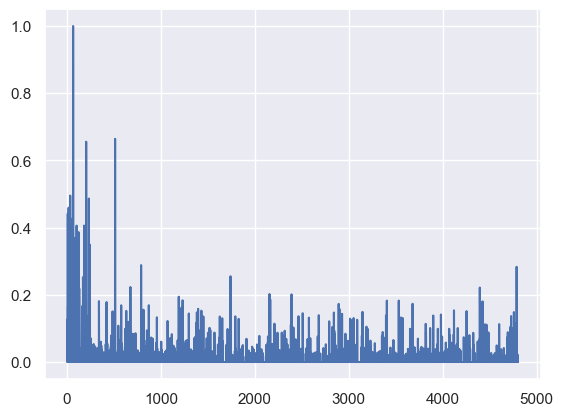

In [18]:
plt.plot(sim)

In [19]:
# Sort the array using the indices. Reverse the sorted array
sim.argsort(), (-sim).argsort()

(array([2401, 3112, 3113, ...,  203,  511,   64]),
 array([  64,  511,  203, ..., 1870, 1855, 4802]))

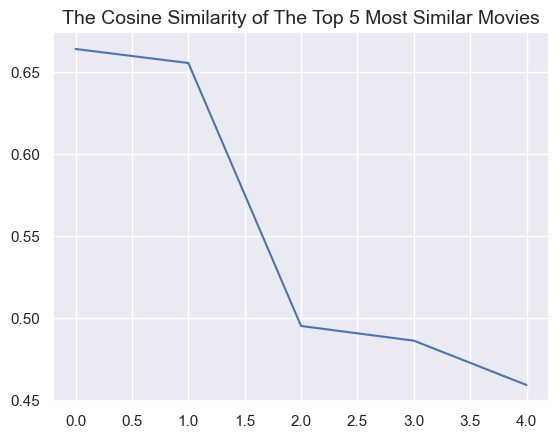

In [20]:
plt.plot(sim[(-sim).argsort()[1:6]])
plt.title("The Cosine Similarity of The Top 5 Most Similar Movies", size=14)
plt.show()

In [21]:
# Get the indices of the top 5 most similar movies.
# Slice from 1 to avoid selecting the actual queried movie.
rec_idx = (-sim).argsort()[1:6]
rec_idx

array([511, 203,  33, 232,  16])

In [22]:
# Display the recommended movies
movie_2_idx.iloc[rec_idx]

title
X-Men                    511
X2                       203
X-Men: The Last Stand     33
The Wolverine            232
The Avengers              16
dtype: int64

### Putting It All Together

In [23]:
def preprocess_data(*, db: pd.DataFrame) -> pd.DataFrame:
    """This is used to prepare the data."""
    db = db.copy()
    columns = ["genres", "keywords", "title"]
    db = db[columns]  # Select relevant columns
    # Preprocess data
    db = db.assign(
        genres=lambda x: x["genres"].apply(extract_values),
        keywords=lambda x: x["keywords"].apply(extract_values),
    )

    db = db.assign(
        preprocessed_feature=db.apply(
            lambda x: concat_columns(x["genres"], x["keywords"]), axis="columns"
        )
    )

    return db


def get_tfidf(*, cleaned_data: pd.DataFrame, max_features: int) -> np.ndarray:
    """This calculates the tf-idf of the data."""
    feature = cleaned_data.columns[-1]
    tfidf = TfidfVectorizer(stop_words="english", max_features=max_features)
    X_tr = tfidf.fit_transform(cleaned_data[feature])
    return X_tr


def get_movie_index_series(*, db: pd.DataFrame) -> pd.Series:
    """This resturns a Pandas Series containing the index of the movies
    and the movie titles."""
    index_series = pd.Series(db.index, index=db["title"])
    return index_series


def select_n_movies(
    *, index_series: pd.Series, similarity: np.ndarray, n: int = 5
) -> list:
    """This selects the `n` top movies."""
    # Select the movies and convert to a list
    result = index_series.iloc[(-similarity).argsort()[1 : n + 1]].index
    result = list(result)
    return result

In [24]:
def movie_recommender(*, db: pd.DataFrame, movie_title: str) -> list:
    """This returns a list of 5 most similar movies."""
    processed_data = preprocess_data(db=db)
    X_tfidf = get_tfidf(cleaned_data=processed_data, max_features=5_000)
    # Obtain Series containing movie index and movie titles
    index_series = get_movie_index_series(db=processed_data)
    query_idx = index_series.loc[movie_title]  # Index of the queried movie
    # Calculate TFIDF of queried movie
    query_tfidf = X_tfidf[query_idx]
    # Calculate similarity
    similarity = cosine_similarity(X=query_tfidf, Y=X_tfidf)
    # Flatten the similarity (i.e convert to 1-D)
    similarity = similarity.flatten()
    rec_movies = select_n_movies(index_series=index_series, similarity=similarity, n=5)
    return {"recommended_movies": rec_movies}

In [25]:
movie_title = "John Carter"

movie_recommender(db=movies_db, movie_title=movie_title)

{'recommended_movies': ['Spaced Invaders',
  'My Favorite Martian',
  'The Last Days on Mars',
  'Guiana 1838',
  'Mission to Mars']}